__[Programmatic Identification of Support/Resistance Trend lines with Python](https://towardsdatascience.com/programmatic-identification-of-support-resistance-trend-lines-with-python-d797a4a90530)__

In [1]:
L1="2800.HK"
start='2018-01-01'
end='2018-12-31'
start_chart=start
end_chart=end

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf 
import talib as TA
from datetime import datetime
#
from findiff import FinDiff

In [3]:
def peak(df,duration):
    peak1=df.rolling(window=duration).max() 
    return(peak1)

def ohlc_gen(stock_code,from1):
    import yfinance as yf
    import talib as TA
    import matplotlib.dates as mdates
    L=[]
    #Fetch daily stock data 
    data = yf.download(stock_code,from1)
    data["Date"]=data.index
    data["Week"]=data["Date"].dt.week
    data["Year"]=data["Date"].dt.year
    #Create weekly data from daily data
    data_weekly=data[data.index>=from1].groupby(["Year","Week"]).agg(
        {"Date":"first",'Open':'first', 'High':'max', 'Low':'min', 'Close':'last','Volume':'sum'})
    #Add TA in daily and weekly data
    data_weekly["Week"]=data_weekly.index
    data_weekly.index=data_weekly["Date"]
    data["EMA9"]=TA.EMA(data["Close"],9)
    data["EMA19"]=TA.EMA(data["Close"],19)
    data["EMA50"]=TA.EMA(data["Close"],50)
    data["RSI9"]=TA.RSI(data["Close"],9)
    data["macd"], data["macdsignal"], data["macdhist"] = TA.MACD(data["Close"], 
                                                           fastperiod=12, 
                                                           slowperiod=26, signalperiod=9)
    #
    data["EMA5"]=TA.EMA(data["Close"],5)
    data["BBupper"], data["BBmid"], data["BBlower"] = TA.BBANDS(data["Close"], 
                                                                timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    data['RSI9-75']=data['RSI9'].rolling(200).apply(lambda x: np.percentile(x, 75))
    data['RSI9-9']=TA.EMA(data["RSI9"],9)
    data['RSI9-19']=TA.EMA(data["RSI9"],19)
    data['RSI9-50']=TA.EMA(data["RSI9"],50)
    data['obv']=TA.OBV(data['Close'], data['Volume'])
    data["obv9"]=TA.EMA(data["obv"],9)
    data["obv19"]=TA.EMA(data["obv"],19)
    data["obv50"]=TA.EMA(data["obv"],50)
    data["peak"]=peak(data["Close"],20)
    data["chaikin"]=TA.ADOSC(data['High'],data['Low'],data['Close'],data['Volume'], fastperiod=3, slowperiod=10)
    data["chaikin3"]=TA.SMA(data["chaikin"],3)
    data["chaikin5"]=TA.SMA(data["chaikin"],5)
    data["chaikin7"]=TA.SMA(data["chaikin"],7)    
    #
    data_weekly["EMA9"]=TA.EMA(data_weekly["Close"],9)
    data_weekly["EMA19"]=TA.EMA(data_weekly["Close"],19)
    data_weekly["EMA50"]=TA.EMA(data_weekly["Close"],50)
    #Construct filtered daily and weekly data for chart generation
    ohlc= data[data.index>=from1][['Date', 'Open', 'High', 'Low',
                                   'Close','EMA9','EMA19','EMA50',"RSI9",'RSI9-75',
                                   'EMA5','BBupper','BBmid','BBlower','obv','obv9','obv19','obv50','peak',
                                   'RSI9-9','RSI9-19','RSI9-50',
                                   "chaikin",'chaikin3','chaikin5','chaikin7',
                                   "macd","macdsignal","macdhist",'Volume']].copy()
    ohlc["Date"] = ohlc["Date"].apply(mdates.date2num)
    ohlc_weekly= data_weekly[['Week', 'Open', 'High', 'Low',
                              'Close','EMA9','EMA19','EMA50','Volume']].copy()
    
    L.append(data)
    L.append(ohlc)
    L.append(ohlc_weekly)
    L.append(data_weekly)
    return(L)

In [4]:
#df=yf.download(L1,'2017-01-01')
OHLC_L=ohlc_gen(L1,"2016-01-01")
OHLC=OHLC_L[1]
data=OHLC_L[0]
#
OHLC_HSI_L=ohlc_gen('^HSI',"2016-01-01")
OHLC_HSI=OHLC_HSI_L[1]
data_HSI=OHLC_HSI_L[0]
    
#candlestick_gen1(OHLC)

[*********************100%***********************]  1 of 1 completed


/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


[*********************100%***********************]  1 of 1 completed


### Find support and resistance

In [5]:
dx = 1 #1 day interval
d_dx = FinDiff(0, dx, 1)
d2_dx2 = FinDiff(0, dx, 2)
clarr = data['Close'].values
mom = d_dx(clarr)
momacc = d2_dx2(clarr)
#
data['mom']=mom
data['momacc']=momacc

In [6]:
data_start='2019-01-01'
data_end='2019-03-31'
data2=data.loc[data_start:data_end].copy()

In [7]:
peak1 = (data2['momacc']<0) & (data2['mom']<0) & (data2['mom'].shift(1)>0) & \
        (data2['Close']>data2['Close'].shift(1))
peak2 = (data2['momacc'].shift(1)<0) & (data2['mom']<0) & (data2['mom'].shift(1)>0) & \
        (data2['Close'].shift(1)>data2['Close'])
peak2=peak2.shift(-1)
peak=peak1 | peak2
peak[peak]

Date
2019-01-11    True
2019-01-21    True
2019-01-25    True
2019-02-13    True
2019-02-25    True
2019-03-06    True
2019-03-12    True
2019-03-19    True
dtype: bool

In [8]:
trough1 = (data2['momacc']>0) & (data2['mom']>0) & (data2['mom'].shift(1)<0) & \
          (data2['Close']<data2['Close'].shift(1))
trough2 = (data2['momacc'].shift(1)>0) & (data2['mom']>0) & (data2['mom'].shift(1)<0) & \
          (data2['Close']>data2['Close'].shift(1))
trough2 = trough2.shift(-1)
trough = trough1 | trough2
trough[trough]

Date
2019-01-14    True
2019-01-22    True
2019-01-29    True
2019-02-15    True
2019-02-28    True
2019-03-08    True
2019-03-13    True
dtype: bool

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


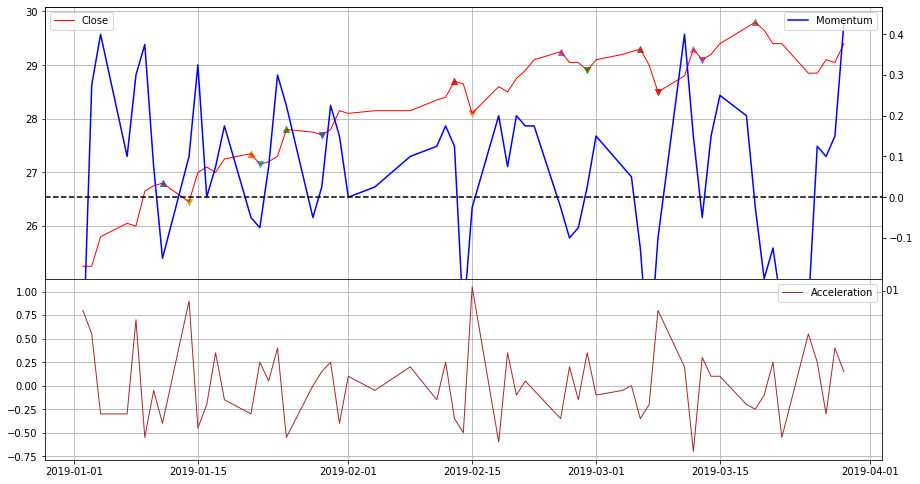

In [9]:
fig = plt.figure(figsize = (15,10))
plt.title("Momentum", loc='left')
ax1 = plt.subplot2grid((6,4), (0,0), rowspan=3, colspan=4)
#
ax1.plot(data2["Date"],data2["Close"],color="red",label="Close",linewidth=1)
ax1.grid(True)
#
for i, v in peak[peak].items(): 
    ax1.scatter(i, data2.loc[i, 'Close'], marker="^")
for i, v in trough[trough].items(): 
    ax1.scatter(i, data2.loc[i, 'Close'], marker="v")
#
ax1_mom = ax1.twinx()
y_lower = np.min(data2['mom']) * 0.5
y_upper = np.max(data2['mom']) * 1.1
ax1_mom.set_ylim(y_lower, y_upper)
ax1_mom.plot(data2["Date"].values,data2['mom'],color="blue",label="Momentum")
ax1_mom.axhline(0,color="black",linestyle="--")
#
ax1_acc = plt.subplot2grid((6,4), (3,0), rowspan=2, colspan=4)
ax1_acc.plot(data2["Date"],data2["momacc"],color="brown",label="Acceleration",linewidth=1)
ax1_acc.grid(True)

plt.subplots_adjust(hspace=0)
ax1.legend(loc="upper left")
ax1_mom.legend(loc="upper right")
ax1_acc.legend(loc="upper right")

In [10]:
data2['mom'].shift(1).head(5)

Date
2019-01-02      NaN
2019-01-03   -0.400
2019-01-04    0.275
2019-01-07    0.400
2019-01-08    0.100
Name: mom, dtype: float64

In [11]:
data2.shape

(60, 35)